In [1]:
import torch
from model import LUNet
from matplotlib import pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from train import training_routine_gaussian, training_routine_uniform, training_routine_uniform_method2
from test import testing_routine
from functions import uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2, gaussian_loss_function

from pathlib import Path

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, compute_gaussian_density

In [2]:
def save_model(model, data = 'Ellipse', checkpoint_number = 31):
    checkpoints_dir= './checkpoints/'
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Saved checkpoint:", save_path)

def load_model(num_lu_blocks=12, layer_size = 2, path=f"./checkpoints/Ellipse/experiment{1}.pth"):
    model = LUNet(num_lu_blocks=num_lu_blocks, layer_size = layer_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [3]:
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

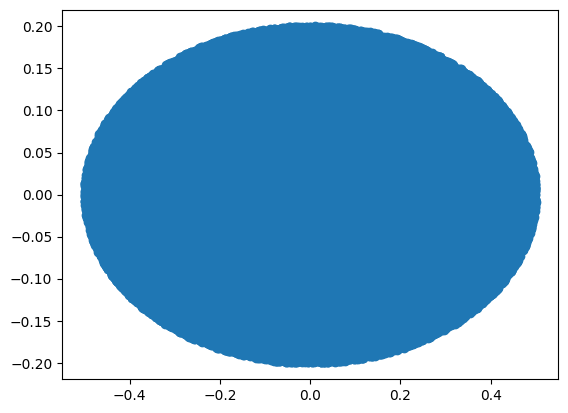

In [4]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(0.5,0.2), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(0.5,0.2), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [5]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [25]:
model = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [16]:
%%time
batch_size = 1024
#density_param=(5,0.2)

# grid points for grid distortion
grid_range = 3
x_range=(-grid_range, grid_range)
y_range=(-grid_range, grid_range)
grid_width = 30

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
grid_input = torch.tensor(all_grid_points).to(device)

def check_not_nan_transform(all_grid_points: torch.Tensor, grid_input: torch.Tensor):
    with torch.no_grad():
        t = model(grid_input, reverse=True)
        return torch.sum(torch.isnan(t)) == 0

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    #density_param = (1+epoch/4, 0.2)
    #print("\nEpoch {}:".format(epoch))
    # if epoch % 100 == 1:
    #     train_with_grid_penalty = check_not_nan_transform(all_grid_points, grid_input)
    #     print(train_with_grid_penalty)

    if epoch % 2 == 3:
        train_with_grid_penalty=True
    else:
        train_with_grid_penalty=False
    
    if train_with_grid_penalty:
        training_routine_uniform_method2(model, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2,
                                        grid_penalty=True, grid_input=grid_input, penalty_weight=1)
    else:
        training_routine_uniform_method2(model, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2)
    
    testing_routine_uniform_method2(model, device, test_loader, batch_size,loss_function=uniform_circle_log_likelihood_method2)
    #save_model_for_animation(model=model, epoch=epoch)
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 59.97it/s]


Test set: Average loss: -2.1125


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 55.15it/s]


Test set: Average loss: -2.0823


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 50.60it/s]


Test set: Average loss: -2.0152


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 48.25it/s]


Test set: Average loss: -2.0939


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 50.23it/s]


Test set: Average loss: -2.0237


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 54.56it/s]


Test set: Average loss: -2.1141


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 51.35it/s]


Test set: Average loss: -1.9801


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 43.40it/s]


Test set: Average loss: -1.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 47.06it/s]


Test set: Average loss: -2.0206


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 45.32it/s]


Test set: Average loss: -2.0493


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 42.25it/s]


Test set: Average loss: -2.0318


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 41.39it/s]


Test set: Average loss: -2.0915


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 40.47it/s]


Test set: Average loss: -1.6841


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 38.78it/s]


Test set: Average loss: -1.8427


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 41.22it/s]


Test set: Average loss: -2.0266


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 42.20it/s]


Test set: Average loss: -1.9471


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 41.67it/s]


Test set: Average loss: -2.1134


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 40.41it/s]


Test set: Average loss: -2.0252


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 39.90it/s]


Test set: Average loss: -2.0306


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 38.19it/s]


Test set: Average loss: -2.0970
CPU times: total: 35.4 s
Wall time: 35.6 s


## Initial training without grid distortion penalty

0

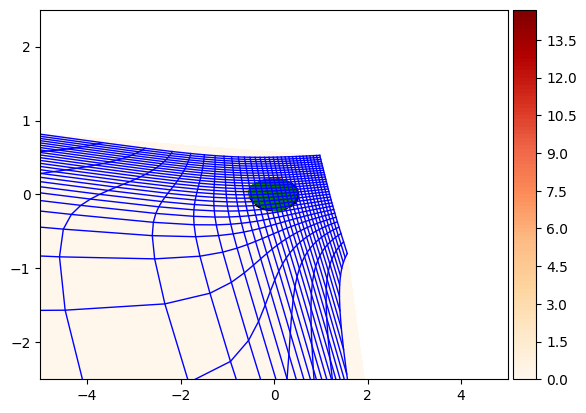

In [10]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

## Trained with grid distortion penalty every second epoch

0

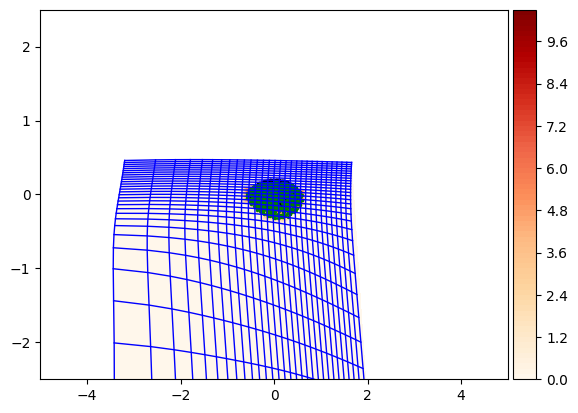

In [14]:
scale=10
factor=3
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

0

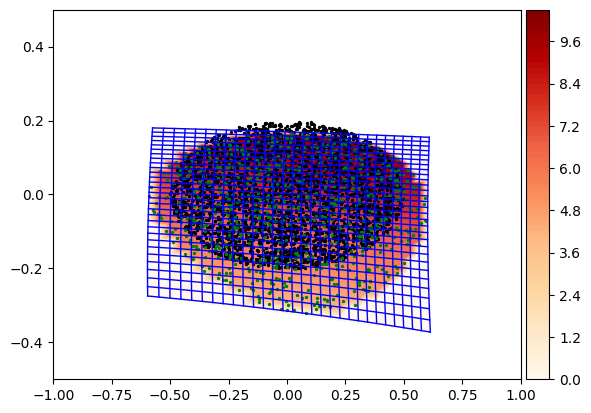

In [15]:
scale=2
factor=1
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

## Train without grid distortion penalty a second time

0

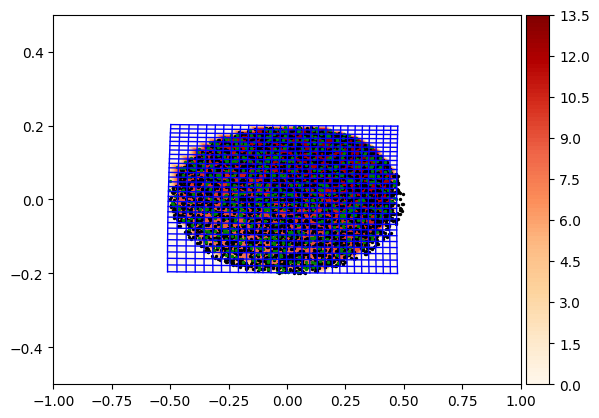

In [17]:
scale=2
factor=1
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

0

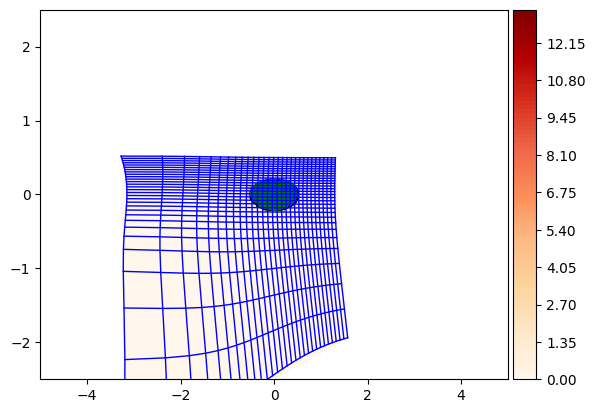

In [20]:
scale=10
factor=3
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

# Banana Data!

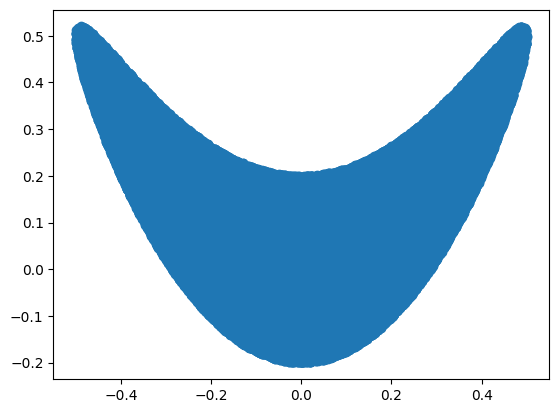

In [80]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [42]:
model_banana = LUNet(num_lu_blocks=2, layer_size = 2).to(device)

In [43]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [53]:
%%time
batch_size = 1024
#density_param=(5,0.2)

# grid points for grid distortion
grid_range = 3
x_range=(-grid_range, grid_range)
y_range=(-grid_range, grid_range)
grid_width = 30

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
grid_input = torch.tensor(all_grid_points).to(device)

def check_not_nan_transform(all_grid_points: torch.Tensor, grid_input: torch.Tensor):
    with torch.no_grad():
        t = model_banana(grid_input, reverse=True)
        return torch.sum(torch.isnan(t)) == 0

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    #density_param = (1+epoch/4, 0.2)
    #print("\nEpoch {}:".format(epoch))
    # if epoch % 100 == 1:
    #     train_with_grid_penalty = check_not_nan_transform(all_grid_points, grid_input)
    #     print(train_with_grid_penalty)

    if epoch % 2 == 3:
        train_with_grid_penalty=True
    else:
        train_with_grid_penalty=False
    
    if train_with_grid_penalty:
        training_routine_uniform_method2(model_banana, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2,
                                        grid_penalty=True, grid_input=grid_input, penalty_weight=1e-3)
    else:
        training_routine_uniform_method2(model_banana, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2)
    
    testing_routine_uniform_method2(model_banana, device, test_loader, batch_size,loss_function=uniform_circle_log_likelihood_method2)
    #save_model_for_animation(model=model_banana, epoch=epoch)
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 34.62it/s]


Test set: Average loss: 0.4839


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 32.11it/s]


Test set: Average loss: 0.3200


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 41.99it/s]


Test set: Average loss: 0.3020


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 29.01it/s]


Test set: Average loss: 0.3083


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 30.16it/s]


Test set: Average loss: 0.3146


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 28.87it/s]


Test set: Average loss: 0.3202


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 30.53it/s]


Test set: Average loss: 0.3258


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 29.21it/s]


Test set: Average loss: 0.3314


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 36.05it/s]


Test set: Average loss: 0.3369


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 37.10it/s]


Test set: Average loss: 0.3424


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 26.82it/s]


Test set: Average loss: 0.3477


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 27.03it/s]


Test set: Average loss: 0.3528


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 26.80it/s]


Test set: Average loss: 0.3578


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 26.85it/s]


Test set: Average loss: 0.3630


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 26.27it/s]


Test set: Average loss: 0.3681


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:03<00:00, 25.32it/s]


Test set: Average loss: 0.3732


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:03<00:00, 25.00it/s]


Test set: Average loss: 0.3782


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 27.88it/s]


Test set: Average loss: 0.3831


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 25.76it/s]


Test set: Average loss: 0.3879


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:03<00:00, 24.78it/s]


Test set: Average loss: 0.3926
CPU times: total: 55.2 s
Wall time: 55.3 s


0

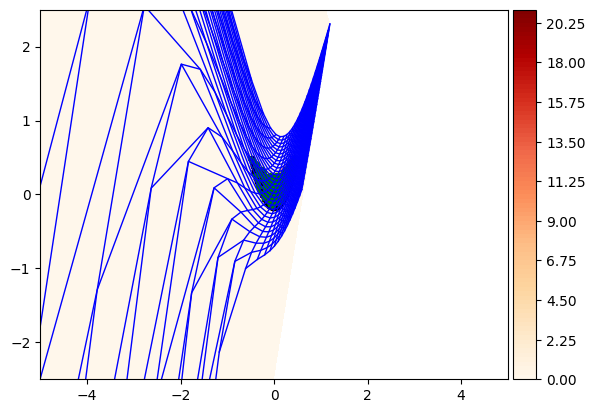

In [45]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

0

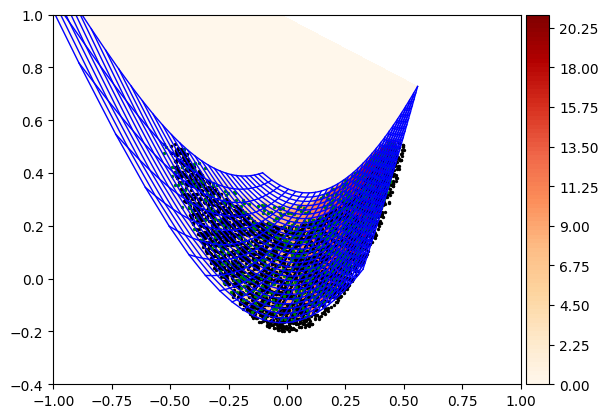

In [46]:
scale=2
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.2*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

## Trained with grid distortion penalty

0

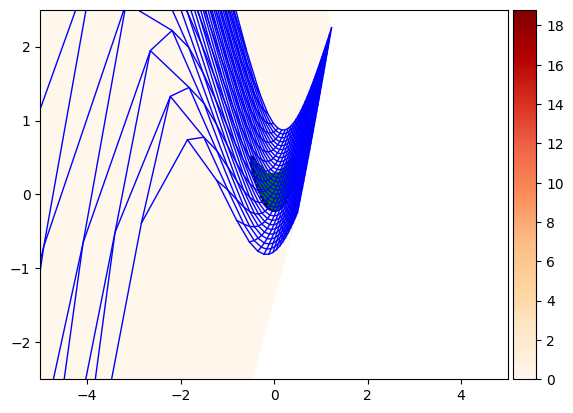

In [51]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

0

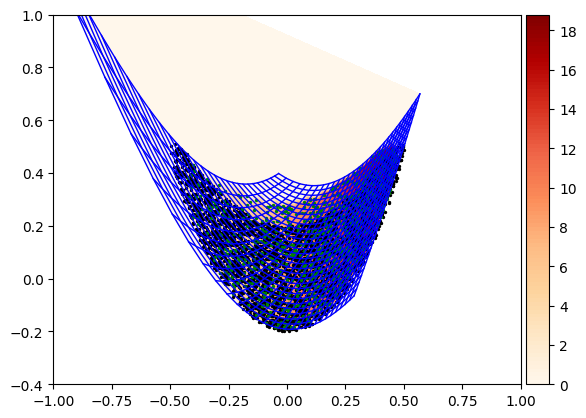

In [52]:
scale=2
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.2*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

## Trained without grid distortion a second time

0

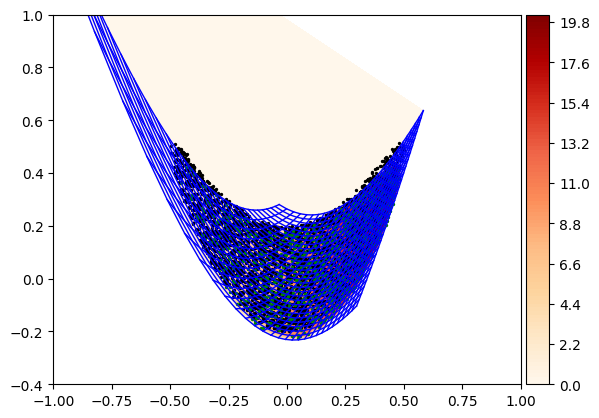

In [56]:
scale=2
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.2*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

0

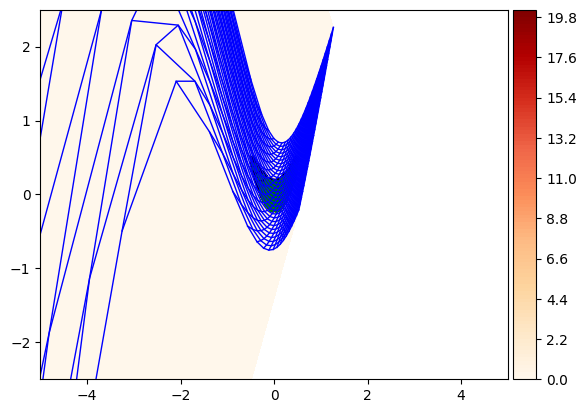

In [57]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

# Weeeeeeeeelllllle!

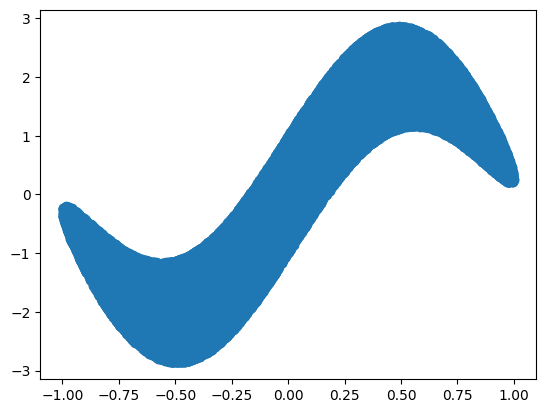

In [173]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [86]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [ ]:
model_wave = load_model(num_lu_blocks=3, layer_size=2, path=f"./checkpoints/Ellipse/experiment{3}.pth")

In [91]:
model_wave = LUNet(num_lu_blocks=3, layer_size = 2).to(device)

In [92]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.3, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [93]:
scheduler.get_last_lr()

[0.3]

In [109]:
%%time
batch_size = 128

# grid points for grid distortion
grid_range = 1.5
x_range=(-grid_range, grid_range)
y_range=(-grid_range, grid_range)
grid_width = 30

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
grid_input = torch.tensor(all_grid_points).to(device)

def check_not_nan_transform(all_grid_points: torch.Tensor, grid_input: torch.Tensor):
    with torch.no_grad():
        t = model_wave(grid_input, reverse=True)
        return torch.sum(torch.isnan(t)) == 0

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    if epoch % 10 == 100:
        train_with_grid_penalty=True
    else:
        train_with_grid_penalty=False

    if train_with_grid_penalty:
        training_routine_uniform_method2(model_wave, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2,
                                        grid_penalty=True, grid_input=grid_input, penalty_weight=1e-15)
    else:
        training_routine_uniform_method2(model_wave, device, train_loader, optimizer, epoch, batch_size, loss_function=uniform_circle_log_likelihood_method2)
    
    testing_routine_uniform_method2(model_wave, device, test_loader, batch_size,loss_function=uniform_circle_log_likelihood_method2)
    #save_model_for_animation(model=model_banana, epoch=epoch)
    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [03:04<00:00,  3.33it/s]


Test set: Average loss: 0.5061


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [02:38<00:00,  3.87it/s]


Test set: Average loss: 0.4896


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [03:37<00:00,  2.82it/s]


Test set: Average loss: 0.3403


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [03:38<00:00,  2.81it/s]


Test set: Average loss: 0.5259


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [04:19<00:00,  2.37it/s]


Test set: Average loss: 0.4762


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [04:22<00:00,  2.34it/s]


Test set: Average loss: 0.4045


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [04:30<00:00,  2.27it/s]


Test set: Average loss: 0.5988


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [05:11<00:00,  1.97it/s]


Test set: Average loss: 0.5685


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [05:29<00:00,  1.86it/s]


Test set: Average loss: 0.5765


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [06:12<00:00,  1.65it/s]


Test set: Average loss: 0.4112


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [06:35<00:00,  1.55it/s]


Test set: Average loss: 0.4454


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [06:49<00:00,  1.50it/s]


Test set: Average loss: 0.2759


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [07:15<00:00,  1.41it/s]


Test set: Average loss: 1.0325


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [07:22<00:00,  1.39it/s]


Test set: Average loss: 0.5825


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [06:06<00:00,  1.67it/s]


Test set: Average loss: 0.2701


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [06:37<00:00,  1.55it/s]


Test set: Average loss: 0.2741


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [08:28<00:00,  1.21it/s]


Test set: Average loss: 0.3943


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [10:04<00:00,  1.02it/s]


Test set: Average loss: 0.3086


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [10:59<00:00,  1.07s/it]


Test set: Average loss: 0.4909


100%|████████████████████████████████████████████████████████████████████████████████| 614/614 [11:51<00:00,  1.16s/it]


Test set: Average loss: 0.3325
CPU times: total: 2h 18min 48s
Wall time: 2h 19min 5s


In [11]:
# for layer in model_wave.intermediate_lu_blocks:
#     print(layer.weight, layer.bias, layer.weight.grad)

In [108]:
save_model(model_wave, data='Wave', checkpoint_number=2)

Saved checkpoint: checkpoints\Wave\experiment2.pth


0

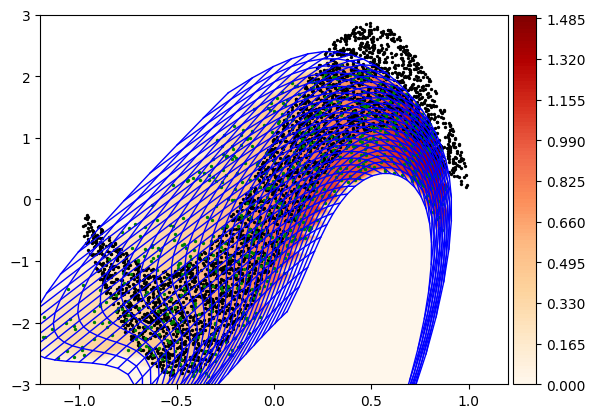

In [95]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

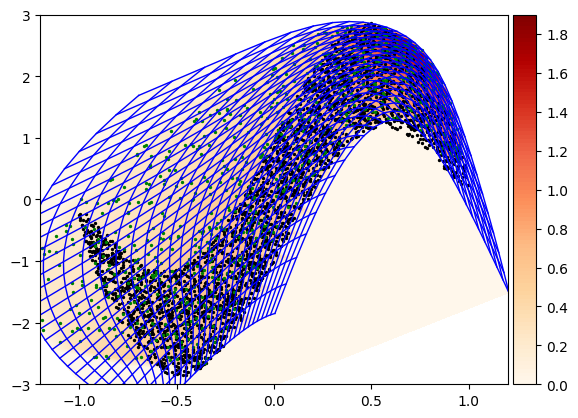

In [103]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

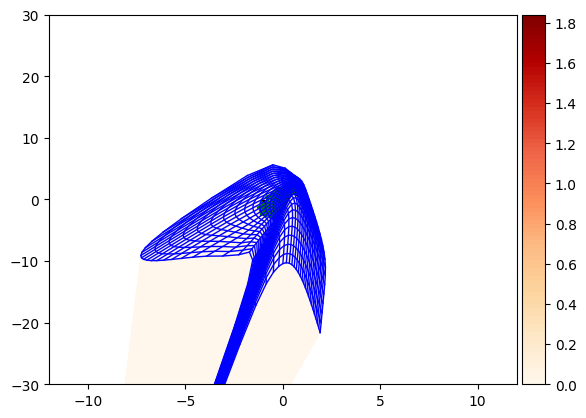

In [101]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [110]:
save_model(model_wave, data ='Wave', checkpoint_number = 3)

Saved checkpoint: checkpoints\Wave\experiment3.pth


0

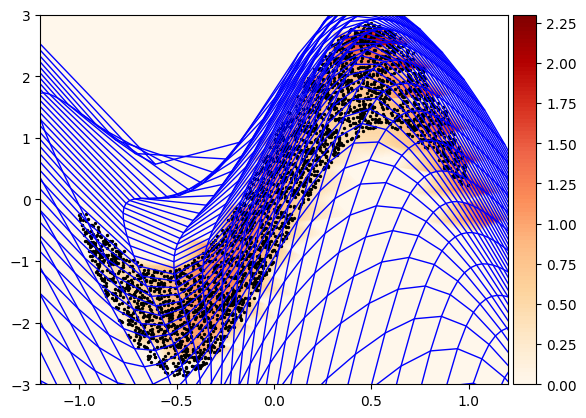

In [116]:
scale=1
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=50,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

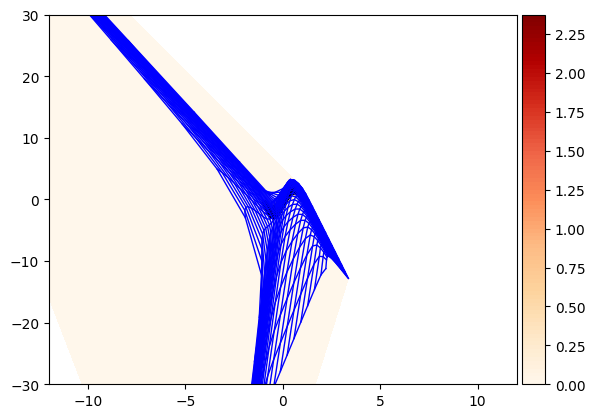

In [112]:
scale=10
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [117]:
save_model(model_wave, data ='Wave', checkpoint_number = 5)

Saved checkpoint: checkpoints\Wave\experiment5.pth


In [5]:
model_wave_2 = load_model(num_lu_blocks=3, layer_size=2, path=f"./checkpoints/Wave/experiment{5}.pth")

0

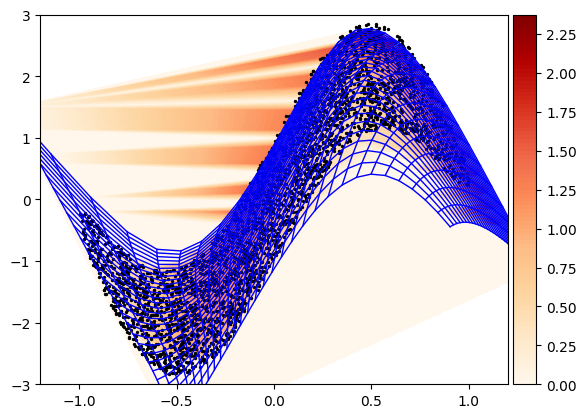

In [10]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave_2, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

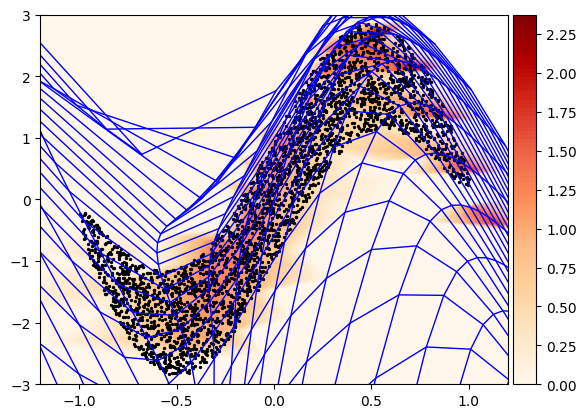

In [14]:
scale=1
factor=3

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave_2, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [46]:
model_wave = LUNet(num_lu_blocks=3, layer_size = 2).to(device)

In [50]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.8, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [61]:
%%time

# grid points for grid distortion
grid_range = 1.5
x_range=(-grid_range, grid_range)
y_range=(-grid_range, grid_range)
grid_width = 30

x = np.linspace(*x_range, grid_width)
y = np.linspace(*y_range, grid_width)

xv, yv = np.meshgrid(x, y, indexing='xy')
horizontal_lines = np.stack((xv, yv), axis=2)
all_grid_points = np.concatenate(horizontal_lines, axis=0)
grid_input = torch.tensor(all_grid_points).to(device)

def check_not_nan_transform(all_grid_points: torch.Tensor, grid_input: torch.Tensor):
    with torch.no_grad():
        t = model_wave(grid_input, reverse=True)
        return torch.sum(torch.isnan(t)) == 0

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    if epoch % 10 == 100:
        train_with_grid_penalty=True
    else:
        train_with_grid_penalty=False

    if train_with_grid_penalty:
        training_routine_uniform_method2(model_wave, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2,
                                        grid_penalty=True, grid_input=grid_input, penalty_weight=1e-15)
    else:
        training_routine_uniform_method2(model_wave, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    
    testing_routine(model_wave, validation_loader, loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:01, 55.33it/s]
62it [00:00, 333.21it/s]


Test set: Average loss: 10.2757


77it [00:01, 70.67it/s]
62it [00:00, 333.85it/s]


Test set: Average loss: 9.4914


77it [00:01, 71.71it/s]
62it [00:00, 310.00it/s]


Test set: Average loss: 9.7373


77it [00:01, 72.27it/s]
62it [00:00, 335.86it/s]


Test set: Average loss: 10.3497


77it [00:01, 74.66it/s]
62it [00:00, 342.31it/s]


Test set: Average loss: 9.2662


77it [00:01, 71.93it/s]
62it [00:00, 331.55it/s]


Test set: Average loss: 9.5457


77it [00:01, 67.72it/s]
62it [00:00, 311.52it/s]


Test set: Average loss: 9.5294


77it [00:01, 69.72it/s]
62it [00:00, 338.19it/s]


Test set: Average loss: 9.0912


77it [00:01, 70.55it/s]
62it [00:00, 331.55it/s]


Test set: Average loss: 9.0113


77it [00:01, 67.89it/s]
62it [00:00, 327.99it/s]


Test set: Average loss: 8.8997


77it [00:01, 68.02it/s]
62it [00:00, 327.79it/s]


Test set: Average loss: 8.7317


77it [00:01, 68.61it/s]
62it [00:00, 334.87it/s]


Test set: Average loss: 8.8885


77it [00:01, 68.35it/s]
62it [00:00, 324.39it/s]


Test set: Average loss: 8.5822


77it [00:01, 67.64it/s]
62it [00:00, 317.90it/s]


Test set: Average loss: 8.6785


77it [00:01, 71.84it/s]
62it [00:00, 338.57it/s]


Test set: Average loss: 8.5344


77it [00:01, 73.27it/s]
62it [00:00, 336.96it/s]


Test set: Average loss: 8.4670


77it [00:01, 68.09it/s]
62it [00:00, 328.04it/s]


Test set: Average loss: 8.5886


77it [00:01, 71.06it/s]
62it [00:00, 336.96it/s]


Test set: Average loss: 8.2994


77it [00:01, 72.26it/s]
62it [00:00, 335.82it/s]


Test set: Average loss: 8.4696


77it [00:01, 69.01it/s]
62it [00:00, 322.86it/s]

Test set: Average loss: 8.1851
CPU times: total: 1min 13s
Wall time: 26.1 s


0

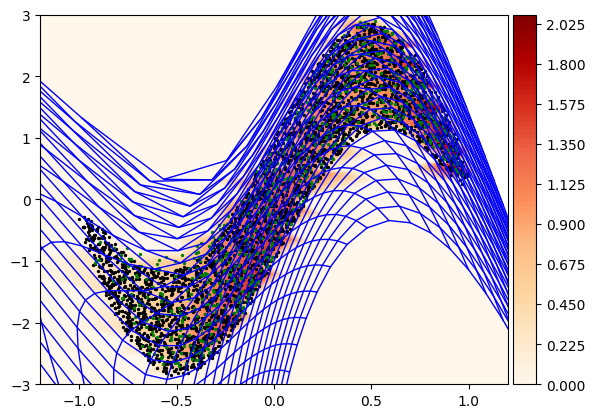

In [62]:
scale=1
factor=2

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

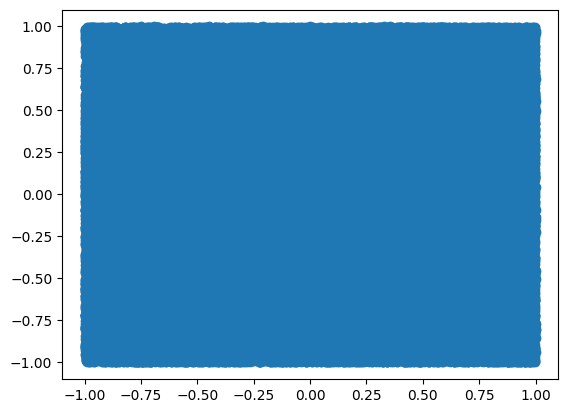

In [154]:
def generate_square(n=100000, scale=(1,1.), device='cpu'):
    data = (torch.rand((n,2), device=device)-0.5)*2
    data *= torch.tensor(scale, device=device)
    return data
training_set = generate_square(n=100000, device=device)
validation_set = generate_square(n=1000, device=device)

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

plt.scatter(np.array(training_set.to('cpu'))[:,0], np.array(training_set.to('cpu'))[:,1])

In [174]:
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=1000, device=device)

# training_set = torch.tensor(np.random.normal(size=(10000,2)), device=device)
# validation_set = torch.tensor(np.random.normal(size=(10000,2)), device=device)
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [16]:
torch.tensor([[120.]], device=training_set.get_device())

tensor([[120.]], device='cuda:0')

In [218]:
model_wave_gaussian = LUNet(num_lu_blocks=3, layer_size = 2).to(device)

In [198]:
model_wave_gaussian(model_wave_gaussian(torch.tensor([[1.2,1.]], device=device), reverse=True))

tensor([[1.2000, 1.0000]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [221]:
optimizer = torch.optim.SGD(model_wave_gaussian.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [236]:
%%time

for epoch in range(1, num_epochs + 1):
    # training_routine_gaussian(model_wave_gaussian, train_loader, optimizer, gaussian_loss_function)
    # testing_routine(model_wave_gaussian, validation_loader, loss_function=gaussian_loss_function)

    training_routine_uniform_method2(model_wave_gaussian, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_wave_gaussian, validation_loader, loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:01, 59.95it/s]
7it [00:00, 333.34it/s]


Test set: Average loss: 6.8479


77it [00:01, 72.63it/s]
7it [00:00, 350.00it/s]


Test set: Average loss: 6.9200


77it [00:01, 74.31it/s]
7it [00:00, 318.16it/s]


Test set: Average loss: 6.3206


77it [00:01, 70.09it/s]
7it [00:00, 304.36it/s]


Test set: Average loss: 6.1799


77it [00:01, 73.02it/s]
7it [00:00, 318.19it/s]


Test set: Average loss: 6.5970


77it [00:01, 71.35it/s]
7it [00:00, 333.34it/s]


Test set: Average loss: 6.2401


77it [00:01, 69.60it/s]
7it [00:00, 333.34it/s]


Test set: Average loss: 6.3179


77it [00:01, 69.53it/s]
7it [00:00, 333.34it/s]


Test set: Average loss: 6.1471


77it [00:01, 69.66it/s]
7it [00:00, 333.35it/s]


Test set: Average loss: 6.2753


77it [00:01, 68.52it/s]
7it [00:00, 318.18it/s]


Test set: Average loss: 5.9990


77it [00:01, 67.19it/s]
7it [00:00, 280.00it/s]


Test set: Average loss: 7.8729


77it [00:01, 71.66it/s]
7it [00:00, 333.35it/s]


Test set: Average loss: 6.4089


77it [00:01, 71.08it/s]
7it [00:00, 333.34it/s]


Test set: Average loss: 6.3160


77it [00:01, 71.54it/s]
7it [00:00, 318.17it/s]


Test set: Average loss: 6.1268


77it [00:01, 71.30it/s]
7it [00:00, 318.17it/s]


Test set: Average loss: 5.8688


77it [00:01, 71.49it/s]
7it [00:00, 318.18it/s]


Test set: Average loss: 5.9732


77it [00:01, 73.95it/s]
7it [00:00, 333.32it/s]


Test set: Average loss: 5.8526


77it [00:01, 70.29it/s]
7it [00:00, 304.34it/s]


Test set: Average loss: 6.6070


77it [00:01, 68.80it/s]
7it [00:00, 318.20it/s]


Test set: Average loss: 5.8300


77it [00:01, 67.98it/s]
7it [00:00, 318.18it/s]

Test set: Average loss: 5.6280
CPU times: total: 50.7 s
Wall time: 22.5 s


C:\Users\Admin\AppData\Local\Temp\ipykernel_21904\34662485.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

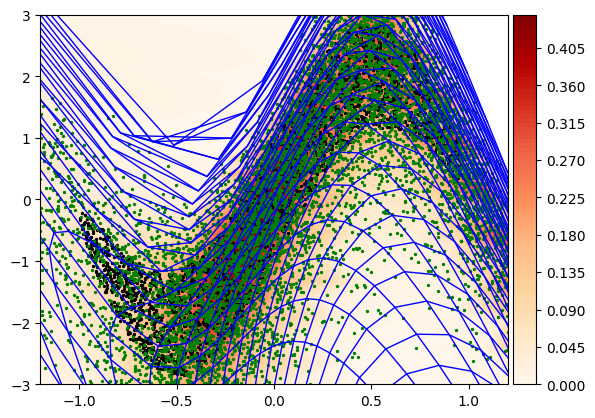

In [237]:
scale=1
factor=3

sampling_data = torch.tensor(np.random.normal(size=(10000,2)))
plot_transformed_grid_and_density(model_wave_gaussian, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_gaussian_density)

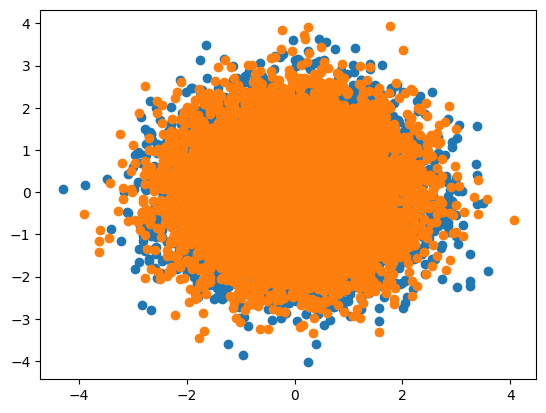

In [87]:
plt.scatter(np.array(training_set.to('cpu'))[:,0], np.array(training_set.to('cpu'))[:,1])

plt.scatter(np.array(torch.tensor(np.random.normal(size=(10000,2))).to('cpu'))[:,0], np.array(torch.tensor(np.random.normal(size=(10000,2))).to('cpu'))[:,1])

In [107]:
def save_model(model, data = 'Ellipse', checkpoint_number = 31):
    checkpoints_dir= './checkpoints/'
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Saved checkpoint:", save_path)

In [95]:
save_model = True
checkpoints_dir= './checkpoints/'
data = 'Ellipse'
checkpoint_number =  31

num_lu_blocks = 2
layer_size = 2

if save_model:
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Saved checkpoint:", save_path)

Saved checkpoint: checkpoints\Ellipse\experiment31.pth


In [4]:
checkpoint_number =  31
num_lu_blocks = 2
layer_size = 2

In [5]:
# checkpoint_number =  4
# num_lu_blocks = 12
# layer_size = 2
# density_param = (1+30/4, 0.2)

def load_model(num_lu_blocks=12, layer_size = 2, path=f"./checkpoints/Ellipse/experiment{checkpoint_number}.pth"):
    model = LUNet(num_lu_blocks=num_lu_blocks, layer_size=layer_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [6]:
model = load_model(num_lu_blocks, layer_size, f"./checkpoints/Ellipse/experiment{checkpoint_number}.pth")

C:\Users\Admin\AppData\Local\Temp\ipykernel_28120\3882102552.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model_inverted(torch.tensor(sampling_data, dtype=torch.float32).to(device))


0

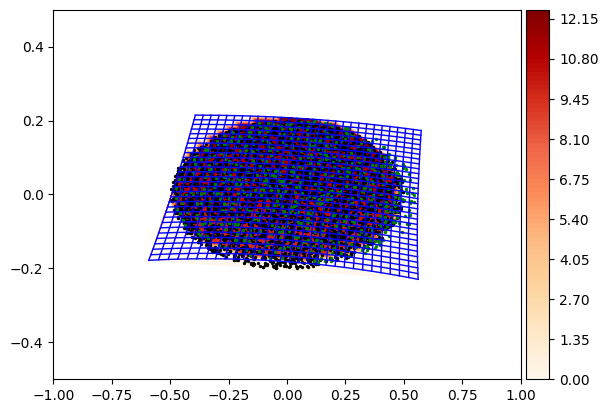

In [177]:
density_param = (1000,0.1)
scale=2
factor=1
plot_generating_uniform_density(model2, inverted_model, device, density_param, train_loader, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

In [15]:
sampling_data = generate_ellipse(1000, (0.1, 0.1))

def inside(model, data):
    output = model(data)
    dist = torch.square(output)
    dist = torch.sum(dist, axis=1) ** 0.5
    result = torch.zeros(output.shape[0], device=device, dtype=torch.bool)
    result[torch.where(dist <= 1)] = True
    return result

inside(model, sampling_data.to(device))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [ ]:
# TODO: 
# - grid distortion (DONE)
# - plot with real density function  (DONE)
# - inside/outside decider (DONE)

# - more complicated shapes
# - 3D shapes 
# - Animation

In [ ]:
def generate_banana():
    train_loader = generate_ellipse(100000)
    train_loader[0, :] = train_loader[0, :] + 3*train_loader[0, :]**2
    return train_loader